<h1>Module 16 Project Clement Nardari</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [30]:
import os
import urllib.request, json
from datetime import datetime
import pymysql
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit

In [31]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"


with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    #print(json.dumps(data, indent=4, sort_keys=True))


Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [33]:
#query the data from the sql db and store it in a data frame
host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)
df.head(4)

,record_num,id,latitude,longitude,direction_id,current_stop_sequence,label,speed,trip_id,stop_id,bus_bearing,occupancy_status,current_status,updated_at
0,1,y1923,42.352740,-71.090408,1,11.0,1923,None,52110816,None,159,FULL,IN_TRANSIT_TO,2022-08-10T18:07:07-04:00
1,2,y1857,42.331279,-71.077037,0,5.0,1857,None,52110882,None,110,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,2022-08-10T18:07:11-04:00
2,3,y1847,42.346760,-71.087410,1,12.0,1847,None,52111045,None,167,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,2022-08-10T18:07:12-04:00
3,4,y1834,42.373212,-71.117565,0,1.0,1834,None,52110945,None,0,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,2022-08-10T18:07:01-04:00



The code below saves the data as a csv file to the local directory as a backup.

In [19]:
#export the data frame in a csv format
df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>


In [20]:
#Compute distance from stop 1 to stop 24
Stop_1=(42.37305838, -71.11755962)
Stop_24=(42.32980513, -71.08425965)

dist=haversine(Stop_1, Stop_24) # in km

In [26]:
#Read db (stored in .csv as backup from sql db container)
df=pd.read_csv('mbta.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             2486 non-null   int64  
 1   record_num             2486 non-null   int64  
 2   id                     2486 non-null   object 
 3   latitude               2486 non-null   float64
 4   longitude              2486 non-null   float64
 5   direction_id           2486 non-null   int64  
 6   current_stop_sequence  2379 non-null   float64
 7   label                  2486 non-null   int64  
 8   speed                  0 non-null      float64
 9   trip_id                2486 non-null   int64  
 10  stop_id                0 non-null      float64
 11  bus_bearing            2486 non-null   int64  
 12  occupancy_status       2484 non-null   object 
 13  current_status         2486 non-null   object 
 14  updated_at             2486 non-null   object 
dtypes: f

In [27]:
#function to tabulate direction id, trip id, start time, en time (first stop, last stop), trip time, avg speed
def trip_info(df,dist):
    #initialize data frame
    trips=pd.DataFrame(columns=['id', 'direction_id', 'start', 'end', 'total_time', 'AVG_speed'])
    #Format for datetime srat and end column
    FMT="%Y-%m-%dT%H:%M:%S%z"  
    #For loop looping through trip_id and finding start time and end time 
    for trip in df['trip_id'].sort_values().drop_duplicates():
        direction=df[(df['trip_id']==trip)]['direction_id'].iloc[0]
        #sort value to find the first time stamp
        sorted_trip=df[(df['trip_id']==trip) & (df['current_stop_sequence']==2)].sort_values('updated_at')

        if len(sorted_trip['updated_at'])>=1:
            start_time=sorted_trip['updated_at'].iloc[0]
            start_time_formated=datetime.strptime(start_time, FMT)
        else:
            start_time=None
        #sort value to find the first time stamp
        sorted_trip=df[(df['trip_id']==trip) & (df['current_stop_sequence']==24)].sort_values('updated_at')

        if len(sorted_trip['updated_at'])>=1:
            end_time=sorted_trip['updated_at'].iloc[0]
            end_time_formated=datetime.strptime(end_time, FMT)
        else:
            end_time=None
        #compute delta t and avg speed only when start and end exist
        if start_time!=None and end_time!=None:

            delta_t=end_time_formated-start_time_formated
            if delta_t.total_seconds()<=0:
                delta_t=None
                speed=None
            else:
                delta_t=delta_t.total_seconds()/60
                speed=dist/delta_t*60
        else:
            delta_t=None
            speed=None
        #populate trips
        temp={'id':trip, 'direction_id':direction ,'start':start_time, 'end':end_time,'total_time':delta_t, 'AVG_speed':speed}
        trips=trips.append(temp, ignore_index=True)
    #drop na
    trips.dropna(inplace=True)
    #format time
    trips["start"] = pd.to_datetime(trips["start"], yearfirst=True, errors='coerce', dayfirst=False, format=FMT)
    trips["end"] = pd.to_datetime(trips["end"], yearfirst=True, errors='coerce', dayfirst=False, format=FMT)
    #return for monday only
    return trips[trips['end'].dt.dayofweek==1]
test=trip_info(df,20)
test.tail(5)

,id,direction_id,start,end,total_time,AVG_speed


In [23]:
test['AVG_speed'].mean() #average trip time both direction

nan

In [24]:
test[test['direction_id']==1]['AVG_speed'].mean() #average trip time direction 1

nan

In [25]:
test[test['direction_id']==0]['AVG_speed'].mean() #average trip time direction 2

nan

<h1>Provide a Visualization based on the data</h1>

In [10]:
#group data by hour of the day 
test['start']=test['start'].dt.hour
dir1=pd.pivot_table(test[test['direction_id']==1],index='start',values='total_time',aggfunc=np.mean)
dir0=pd.pivot_table(test[test['direction_id']==0],index='start',values='total_time',aggfunc=np.mean)


(10,)
(10,)


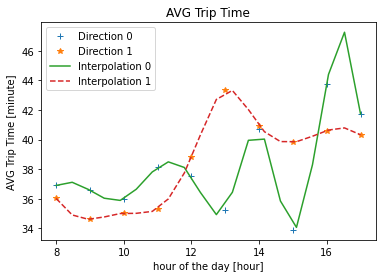

In [13]:
#Plot for each direction total time function of start time
x0 = np.array(dir0.index)
x1 = np.array(dir1.index)
y0 = np.array(dir0.values).squeeze()
y1 = np.array(dir1.values).squeeze()

print(x0.shape)
print(y0.shape)
f0 = interp1d(x0, y0, kind='cubic')
f1 = interp1d(x1, y1, kind='cubic')
xnew = np.linspace(8, 17, num=20, endpoint=True)

plt.plot(x0, y0, '+', x1, y1, '*', xnew , f0(xnew), '-', xnew , f1(xnew), '--')
plt.legend(['Direction 0', 'Direction 1', 'Interpolation 0', 'Interpolation 1'], loc='best')
plt.xlabel('hour of the day [hour]')
plt.ylabel('AVG Trip Time [minute]')
plt.title('AVG Trip Time')
plt.show()

<AxesSubplot:xlabel='start', ylabel='total_time'>

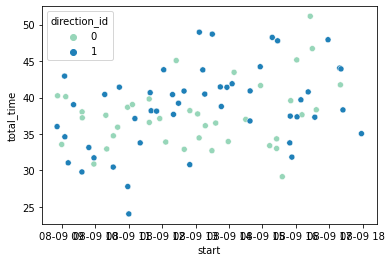

In [9]:
#Plot for each direction total time function of start time
sns.scatterplot(x=test['start'],y=test['total_time'],hue=test['direction_id'],palette='YlGnBu')


<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [13]:
#group data by hour of the day 
test['start']=test['start'].dt.hour
dir1=pd.pivot_table(test[test['direction_id']==1],index='start',values='AVG_speed',aggfunc=np.mean)
dir0=pd.pivot_table(test[test['direction_id']==0],index='start',values='AVG_speed',aggfunc=np.mean)

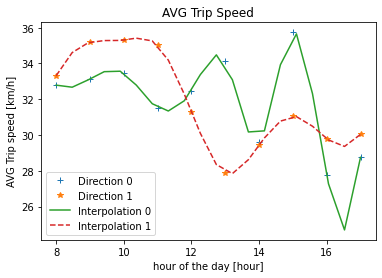

In [15]:
#Plot for each direction AVG speed function of start time
x0 = np.array(dir0.index)
x1 = np.array(dir1.index)
y0 = np.array(dir0.values).squeeze()
y1 = np.array(dir1.values).squeeze()

f0 = interp1d(x0, y0, kind='cubic')
f1 = interp1d(x1, y1, kind='cubic')
xnew = np.linspace(8, 17, num=20, endpoint=True)

plt.plot(x0, y0, '+', x1, y1, '*', xnew , f0(xnew), '-', xnew , f1(xnew), '--')
plt.legend(['Direction 0', 'Direction 1', 'Interpolation 0', 'Interpolation 1'], loc='best')
plt.xlabel('hour of the day [hour]')
plt.ylabel('AVG Trip speed [km/h]')
plt.title('AVG Trip Speed')
plt.show()